In [ ]:
# CCDカメラで取得した画像から、ラマンスペクトルを作成する
# やること
# 1. 画像の読み込み
# 2. ラマンスペクトルの作成
# 3. ラマンスペクトルのプロット (matplotlib)
# 4. ラマンスペクトルの保存 (csv)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [3]:
class RamanSpectrum:
    def __init__(self, img_path):
        self.img_path = img_path

    def read_img(self):
        return cv2.imread(self.img_path, cv2.IMREAD_GRAYSCALE)
    
    def pixel_to_wavenumber(self, pixel):
        # kaiserの式のマジックナンバーたちは、設計に基づいた数値であることに注意
        kaiser = 1.87970*10**4 - 10**7/(532 + (633 - 532)/1440 * pixel)
        return kaiser

    def get_raman_intensity(self):
        img = self.read_img()
        height, width = img.shape[:2]
        raman_intensity = []
        for x in range(width):
            sum_intensity = 0
            for y in range(height):
                intensity_of_pixel = img[y, x]
                sum_intensity += intensity_of_pixel
            raman_intensity.append(sum_intensity/height)
        return raman_intensity

    def get_raman_wavenumber(self):
        img = self.read_img()
        height, width = img.shape[:2]
        raman_wavenumber = []
        for x in range(width):
            raman_wavenumber.append(self.pixel_to_wavenumber(x))
        return raman_wavenumber
        
    def get_spectrum(self, file_name):
        raman_intensity = self.get_raman_intensity()
        raman_wavenumber = self.get_raman_wavenumber()
        plt.xlabel('Wavenumber (cm-1)')
        plt.ylabel('Raman Intensity')
        plt.plot(raman_wavenumber, raman_intensity)
        plt.savefig(f'data/img/{file_name}.png')

    def save_spectrum(self, file_name):
        df = pd.DataFrame({'Wavenumber': self.get_raman_wavenumber(), 'Intensity': self.get_raman_intensity()})
        df.to_csv(f'data/csv/{file_name}.csv')

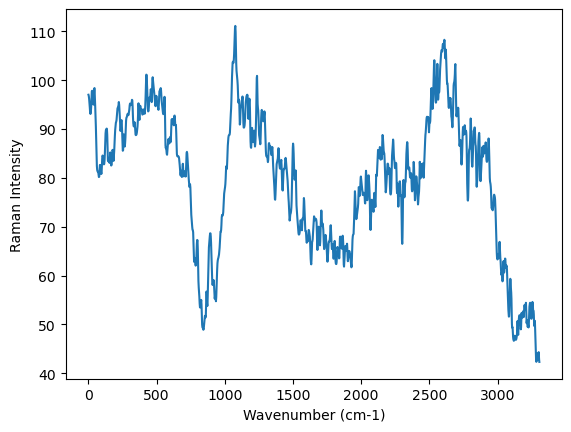

In [11]:
resource_path = "data/img/IMG_8647.jpeg"
resource = RamanSpectrum(resource_path)
resource.get_spectrum('spectrum_2')
resource.save_spectrum('spectrum_2')

In [ ]:
# データの前処理
# 1. 平滑化
# 2. エッジ抽出
# 3. 鮮鋭化
# 4. モルフォロジー変換

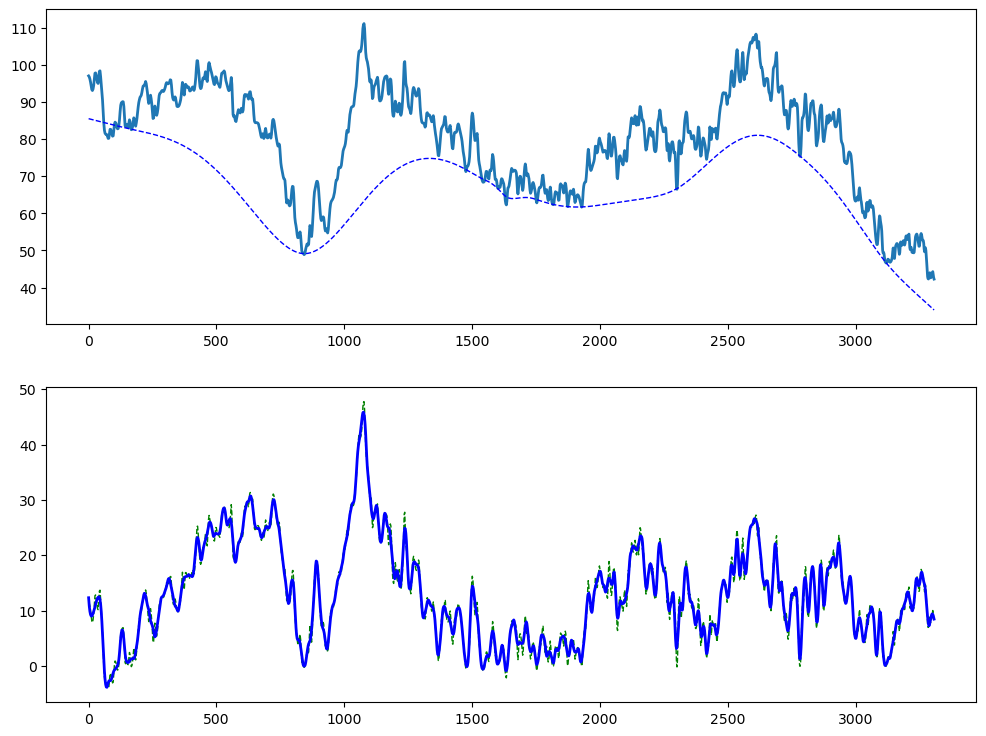

In [26]:
# 以下のコードは次のサイトを参考にしている
# https://qiita.com/lcmtk/items/06bdd965d8a79bbfd0a9

import csv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse import spdiags
import scipy.sparse.linalg as spla

#パラメタを入力します、うまく推定ができないときはここをいじってください
#AsLSでのベースライン推定は ( W(p) + lam*D'D )z = Wy のとき、重み p と罰則項の係数 lam がパラメタです
#Savitzky-Golyでは、測定値をいくつに分割するかを dn で設定し（窓の数は len(Y)/dn になります)、多項式次数を poly で設定します
# paramAsLS = [ lam , p ]
# paramSG   = [ dn , poly ]
paramAsLS = [10**3.5, 0.00005]
paramSG = [80, 5]

# 以下のファイルを読み込みます
filename = 'data/csv/spectrum_2.csv'


# 測定データ(csv)を開きます
X = []
Y = []
with open(filename, 'r') as f:
    header = next(csv.reader(f))
    reader = csv.reader(f)
    data = [row for row in reader]
    for i in range(len(data)):
        X.append(float(data[i][1]))
        Y.append(float(data[i][2]))

# AsLSによりベースライン推定を行います
def baseline_als(y, lam, p, niter=10):
    #https://stackoverflow.com/questions/29156532/python-baseline-correction-library
    #p: 0.001 - 0.1, lam: 10^2 - 10^9
    # Baseline correction with asymmetric least squares smoothing, P. Eilers, 2005
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spla.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

# Savitzky-Golyによりノイズ除去を行います
def SGs(y,dn,poly):
    # y as np.array, dn as int, poly as int
    n = len(y) // dn
    if n % 2 == 0:
        N = n+1
    elif n % 2 == 1:
        N = n
    else:
        print("window length can't set as odd")
    SGsmoothed = signal.savgol_filter(y, window_length=N, polyorder=poly)
    return SGsmoothed

# csvファイルと図を出力します
def outFigCSV(X,Y,paramAsLS, paramSG):

    # baseline estimation and smoothing
    Y_np = np.array(Y)
    # baseline estimation
    bkg = baseline_als(Y_np,paramAsLS[0], paramAsLS[1])
    fix = Y_np - bkg # remove baseline
    # smoothing
    smth= SGs(fix, paramSG[0], paramSG[1])

    # csv output
    dataOutput = np.c_[X, Y, bkg, smth]
    np.savetxt('data/csv/processed_2.csv', dataOutput, delimiter=',')

    #figures
    plt.figure(figsize=(12,9))
    ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
    ax2 = plt.subplot2grid((2,2), (1,0), colspan=2)

    ax1.plot(X, Y, linewidth=2)
    ax1.plot(X, bkg, "b", linewidth=1, linestyle = "dashed", label="baseline")

    ax2.plot(X, fix, "g", linewidth=1, linestyle = "dashed", label="remove baseline")
    ax2.plot(X, smth, "b", linewidth=2, label="smoothed")

    plt.axis("tight")
    plt.show()

# 実行する
outFigCSV(X,Y,paramAsLS, paramSG)
